# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (ther can be multiple things as the options).

Book version of notebook at -> https://www.learnpytorch.io/02_pytorch_classification/

## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"first 5 sample of X:\n {X[:5]}")
print(f"first 5 sample of y:\n {y[:5]}")

first 5 sample of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 sample of y:
 [1 1 1 1 0]


In [5]:
# make Dataframe of circle data
import pandas as pd
circles = pd.DataFrame({
                        "X1": X[:, 0], 
                        "X2": X[:, 1],
                        "label": y
                        })

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


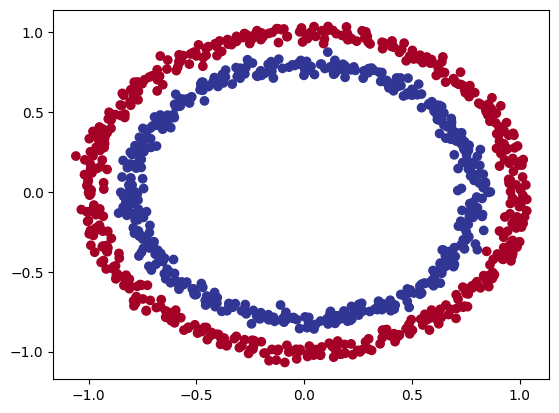

In [6]:
# Visualize, Visualize, Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often refered to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practive the fundamentals.

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first eg of features an lables
X_sample = X[0]
y_sample = y[0]

print(f"values for one sample of X: {X_sample} ans the same for y: {y_sample}")
print(f"shapes for one sample of X: {X_sample.shape} ans the same for y: {y_sample.shape}")

values for one sample of X: [0.75424625 0.23148074] ans the same for y: 1
shapes for one sample of X: (2,) ans the same for y: ()


### 1.2 Turn dat into tensors and create train and test splits

In [10]:
import torch

In [11]:
torch.__version__

'2.5.1'

In [12]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [13]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # converting into float32 pytorch default dtype
y = torch.from_numpy(y).type(torch.float) # converting into float32 pytorch default dtype

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [15]:
# split data into traingin and test sets
from sklearn.model_selection import train_test_split

In [22]:
train_test_split??

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Source:   
@validate_params(
    {
        "test_size": [
            Interval(RealNotInt, 0, 1, closed="neither"),
            Interval(numbers.Integral, 1, None, closed="left"),
            None,
        ],
        "train_size": [
            Interval(RealNotInt, 0, 1, closed="neither"),
            Interval(numbers.Integral, 1, None, closed="left"),
            None,
        ],
        "random_state": ["random_state"],
        "shuffle": ["boolean"],
        "stratify": ["array-like", None],
    },
    prefer_skip_nested_validation=True,
)
def train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
):
    """Split arrays or matrices into random train and test subsets.

    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and appli

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    train_size=0.8, 
                                                    random_state=42
                                                    )

In [17]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2.  Building a model

Building a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Build a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
3. Create a training and test loop

In [18]:
#  import PyTorch and nn
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` 
2. Create 2 `nn.Linear()` layers that a capable of handling the shape of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to target `device`

In [19]:
X_train.shape

torch.Size([800, 2])

In [20]:
# Construct a model that subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous later and outputs a single feature (same shape as y)
        
        # anoter method
        # self.two_linear_layters = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # ).to(device)
        
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, X):
        return self.layer_2(self.layer_1(X)) # X -> layer_1 -> layer_2 -> output
    
    
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device=device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
next(model_0.parameters()).device

device(type='cpu')

In [29]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device=device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3861,  0.2353],
                      [ 0.5615, -0.1097],
                      [-0.3263, -0.5779],
                      [ 0.0984, -0.0427],
                      [-0.0831, -0.2588]])),
             ('layer_1.bias',
              tensor([-0.5822, -0.2366,  0.4126,  0.4267, -0.6180])),
             ('layer_2.weight',
              tensor([[ 0.1443, -0.0860,  0.2961,  0.1791, -0.0545]])),
             ('layer_2.bias', tensor([-0.2806]))])

In [23]:
# make predictions
with torch.inference_mode():
    untrainted_preds = model_0(X_test.to(device))
print(f'len of prediction: {len(untrainted_preds)}, Shape: {untrainted_preds.shape}')
print(f'len of test sample: {len(X_test)}, Shape: {X_test.shape}')
print(f"\nFirst 10 predictions:\n{torch.round(untrainted_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

len of prediction: 200, Shape: torch.Size([200, 1])
len of test sample: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [-0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer


Which loss function or optimier should you use?

Again... this is problem specific

For eg. for regression you might use MAE or MSE(mean absolute error mean squared error)

For classificaion you might use binary cross entropy or categorical cross entropy(cross entropy).

As a reminder, the loss fn measure how wrong your models predictions are...

And for optimizers, two of themost common and useful are SGD and ADAM, however PyTorch has a ton of them

* for common choices of loss fns and optimizers - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer
* For loss fn we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on the Binary Cross Entropy (BCE) is, check out this article by Daniel Grody Medium
* For definion on what logit is in deep learning - stackoverflow and google it
* for different optimizer see `torch.optim` 


In [24]:
# Setup the loss fn

# loss_fn = nn.BCELoss() # BCELoss -> requires inputs to have gone through sigmoid activation funtion prior to input or BCELoss

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss -> this has the sigmoid acivation function  built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [25]:
# calculate accuracy - out of 100 eg, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we're going to need to build a training loop with ff steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer Step(gradient descent)

### 3.1 Going form raw logits -> prediction probailites -> predicion labels

Our model outputs are going to be raw **logits**

We can coverts these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [26]:
# View the first 5 output of the forward pass on the test data

# making predict without training
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1278],
        [-0.2312],
        [ 0.0517],
        [-0.1783],
        [-0.0936]])

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [36]:
# Use the sigmoid activation funtion on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs, torch.round(y_pred_probs)

(tensor([[0.4681],
         [0.4425],
         [0.5129],
         [0.4556],
         [0.4766]]),
 tensor([[0.],
         [0.],
         [1.],
         [0.],
         [0.]]))

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5 `y=1` (class 1)
* `y_pred_probs` < 0.5 `y=0` (class 0)

In [31]:
# find the predicted label
y_preds = torch.round(y_pred_probs)

# in full (logits -> pred probs -> pred labels)
y_pred_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
# visualize! visualize! visualize! visualize!
print("hmmmm curious🤔, whats happen' in the torch.eq().sum().item(). so i broke it down here ⬇️⬇️⬇️")
print(f"torch.eq -> {torch.eq(y_preds.squeeze(), y_pred_label.squeeze())}")
print(f"torch.eq().sum() -> {torch.eq(y_preds.squeeze(), y_pred_label.squeeze()).sum()} , type -> {type(torch.eq(y_preds.squeeze(), y_pred_label.squeeze()).sum())}")
print(f"torch.eq().sum().item() -> {torch.eq(y_preds.squeeze(), y_pred_label.squeeze()).sum().item()}, type -> {type(torch.eq(y_preds.squeeze(), y_pred_label.squeeze()).sum().item())}")

# get rid of extra dimensions
y_preds.squeeze()

torch.eq -> tensor([True, True, True, True, True])
torch.eq().sum() -> 5 , type -> <class 'torch.Tensor'>
torch.eq().sum().item() -> 5, type -> <class 'int'>


tensor([0., 0., 1., 0., 0.])

### 3.2 Building a training and testing loop

In [38]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 1000

# put data to target data
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build the training and eval loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. forward pass
    y_logits = model_0.forward(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
    
    
    # 2. calculate the loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # if this was nn.BCELoss, it expects prediction probabilites as input
    #                y_train)
    
    loss = loss_fn(y_logits, # nn.BCEWithLogitLoss expects raw logits as input for numberical stability
                   y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Opitmizer zero grad 
    optimizer.zero_grad()
    
    # 4. Loss backward (backwardpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    ### testing
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # cal. test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    # print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70280, Acc: 50.50% | Test loss: 0.70196, Test acc: 53.50%
Epoch: 10 | Loss: 0.70025, Acc: 49.88% | Test loss: 0.69946, Test acc: 51.50%
Epoch: 20 | Loss: 0.69890, Acc: 50.00% | Test loss: 0.69811, Test acc: 50.50%
Epoch: 30 | Loss: 0.69804, Acc: 50.00% | Test loss: 0.69724, Test acc: 48.50%
Epoch: 40 | Loss: 0.69742, Acc: 50.50% | Test loss: 0.69663, Test acc: 45.50%
Epoch: 50 | Loss: 0.69694, Acc: 50.50% | Test loss: 0.69616, Test acc: 45.00%
Epoch: 60 | Loss: 0.69654, Acc: 50.38% | Test loss: 0.69579, Test acc: 44.50%


Epoch: 70 | Loss: 0.69620, Acc: 50.75% | Test loss: 0.69548, Test acc: 44.50%
Epoch: 80 | Loss: 0.69591, Acc: 50.75% | Test loss: 0.69523, Test acc: 45.00%
Epoch: 90 | Loss: 0.69565, Acc: 50.88% | Test loss: 0.69503, Test acc: 45.00%
Epoch: 100 | Loss: 0.69543, Acc: 50.88% | Test loss: 0.69485, Test acc: 45.00%
Epoch: 110 | Loss: 0.69523, Acc: 50.88% | Test loss: 0.69470, Test acc: 45.00%
Epoch: 120 | Loss: 0.69506, Acc: 50.88% | Test loss: 0.69458, Test acc: 44.50%
Epoch: 130 | Loss: 0.69490, Acc: 50.88% | Test loss: 0.69448, Test acc: 44.50%
Epoch: 140 | Loss: 0.69476, Acc: 50.62% | Test loss: 0.69439, Test acc: 44.50%
Epoch: 150 | Loss: 0.69464, Acc: 50.62% | Test loss: 0.69431, Test acc: 44.50%
Epoch: 160 | Loss: 0.69452, Acc: 50.75% | Test loss: 0.69425, Test acc: 44.50%
Epoch: 170 | Loss: 0.69442, Acc: 50.50% | Test loss: 0.69419, Test acc: 45.00%
Epoch: 180 | Loss: 0.69432, Acc: 50.50% | Test loss: 0.69415, Test acc: 45.50%
Epoch: 190 | Loss: 0.69423, Acc: 50.50% | Test loss: 0.

## 4. make predictions and eval the model

from the metrics it looks like our mdel isn't learning anything...

so to inspect it, let's make some predictions and make them visual! 

visualize, visualize, visualise

to do so, we're going to import a function called `plot_decision_boundary()`

In [39]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded)
file_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"
if Path("helper_functions.py").is_file():
    print("helper_function.py already exist, skipping download")
else:
    print("Download helper_function.py")
    requests = requests.get(url=file_url)
    with open("helper_functions.py", "wb") as f:
        f.write(requests.content)

helper_function.py already exist, skipping download


In [40]:
from helper_functions import plot_predictions, plot_decision_boundary

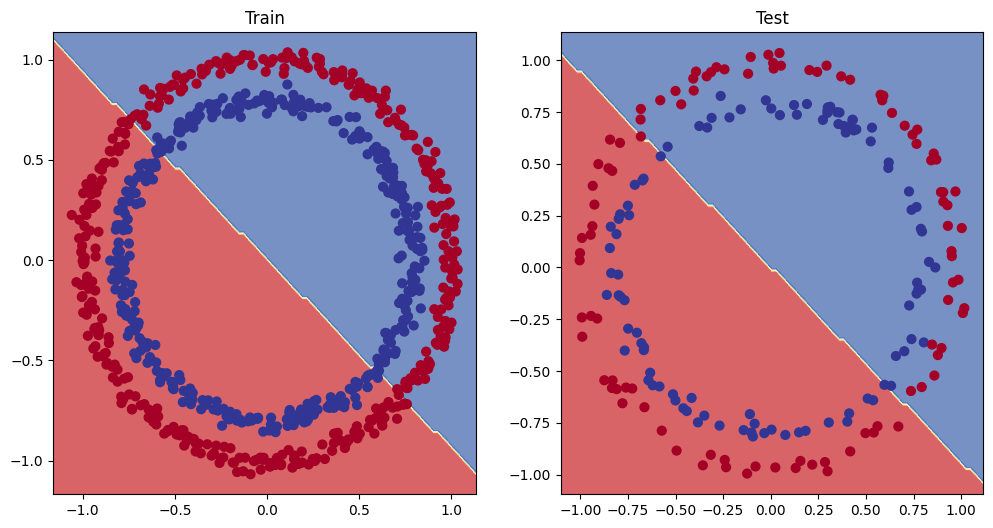

In [41]:
# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model(from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden unit to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal with the model directly, rather than the data

And beacuase these options are ll values we (we as ML engienner and data scientist) can change, they are referred as **hyperparameters**.

Let's try and improve out model by:
* adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [42]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [43]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
        
    def forward(self, X):
        
        # another way to do it
        # z = self.layers_1(X)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z

        # for speed up, do method chainging -> this way of writing operations leverages speed ups where possible behind the scenes
        return self.layer_3(self.layer_2(self.layer_1(X)))
    
    
model_1 = CircleModelV1().to(device=device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
list(model_1.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998],
         [ 0.5451,  0.1045],
         [-0.3301,  0.1802]], requires_grad=True),
 Parameter containing:
 tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
          0.0667, -0.6984], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
           0.0346, -0.0997],
         [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
           0.1606, -0.1927],
         [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,
           0.2475, -0.2247],
         [ 0.0199, -0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874,
          -0.1886, -0.1886],
         [ 0.2844,  0.1054,  0.3043, -0.2610,

In [45]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [46]:
# Create a loss function
loss_fn1 = nn.BCEWithLogitsLoss()

# Creat an optimizer
optimizer1 = torch.optim.SGD(params=model_1.parameters(), lr=0.001)

In [47]:
# write a training and eval loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 1000

# put data to target data
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # train
    model_1.train()
    
    # do the forward pass
    y_logits_1 = model_1.forward(X_train).squeeze()
    y_preds_1 = torch.round(torch.sigmoid(y_logits_1))
    
    # cal. the loss/acc
    loss_1 = loss_fn1(y_logits_1, y_train)
    acc_1 = accuracy_fn(y_true=y_train, y_pred=y_preds_1)
    
    # optimizer zero grads
    optimizer1.zero_grad()
    
    # loss backwards (backpropagate)
    loss_1.backward()
    
    # optimizer step (gradient descent)
    optimizer1.step()
    
    
    # evaluate the model
    model_1.eval()
    with torch.inference_mode():
        # do the forwards pass 
        test_logits_1 = model_1(X_test).squeeze()
        test_preds_1 = torch.round(torch.sigmoid(test_logits_1))
        
        # cal. the loss
        test_loss_1 = loss_fn1(test_logits_1, y_test)
        test_acc_1 = accuracy_fn(y_true=y_test, y_pred=test_preds_1)
        
    # print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_1:.5f}, Acc: {acc_1:.2f}% | Test loss: {test_loss_1:.5f}, Test acc: {test_acc_1:.2f}%")
        

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 10 | Loss: 0.69395, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 20 | Loss: 0.69395, Acc: 50.75% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 30 | Loss: 0.69394, Acc: 50.75% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 40 | Loss: 0.69394, Acc: 50.75% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 50 | Loss: 0.69394, Acc: 50.75% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 60 | Loss: 0.69394, Acc: 50.75% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 70 | Loss: 0.69393, Acc: 50.75% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 80 | Loss: 0.69393, Acc: 50.62% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 90 | Loss: 0.69393, Acc: 50.62% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69392, Acc: 50.50% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 110 | Loss: 0.69392, Acc: 50.62% | Test loss: 0.69262, Test acc: 51.00%
Epoch: 120 | Loss: 0.69392, Acc: 50.62% | Test loss: 0.69262, T

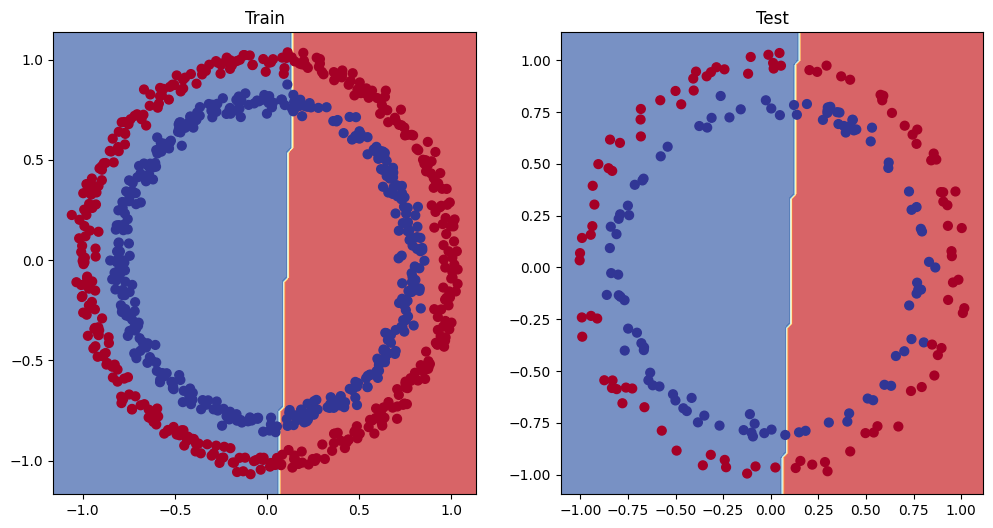

In [48]:
# plot the decision boundary
# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if out model can fit a straight line

One way troubleshoot to a latfer problem is to test out a smaller problem

In [62]:
import torch

In [107]:
weight = 0.7
bias = 0.3

X_regression = torch.arange(0, 10, 0.1).to(device=device).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.1000],
         [0.2000],
         [0.3000],
         [0.4000]]),
 tensor([[0.3000],
         [0.3700],
         [0.4400],
         [0.5100],
         [0.5800]]))

In [108]:
# spliting data

train_split = int(0.8 * len(X_regression))
print(train_split)
X_regression_train, y_regression_train = X_regression[:train_split], y_regression[:train_split]
X_regression_test, y_regression_test = X_regression[train_split:], y_regression[train_split:]

len(X_regression_train), len(X_regression_test), len(y_regression_train), len(y_regression_test)

80


(80, 20, 80, 20)

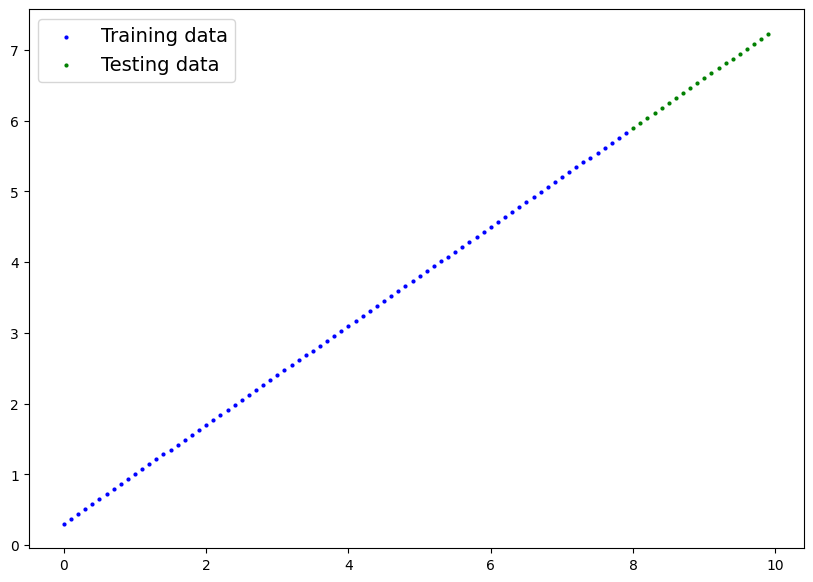

In [89]:
plot_predictions(train_data=X_regression_train, train_labels=y_regression_train, test_data=X_regression_test, test_labels=y_regression_test)

### 5.2 Adjust `model_1` to fit a straight line

In [109]:
# same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=32),
    nn.Linear(in_features=32, out_features=32),
    nn.Linear(in_features=32, out_features=1),
)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Linear(in_features=32, out_features=32, bias=True)
  (2): Linear(in_features=32, out_features=1, bias=True)
)

In [110]:
# Loss and optimizer
loss_fn_2 = nn.L1Loss()
optimizer2 = torch.optim.SGD(params=model_2.parameters(), lr=0.001)

In [115]:
# train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epochs
epochs = 1000

# put the data on the target device
X_regression_train, y_regression_train = X_regression_train.to(device), y_regression_train.to(device)
X_regression_test, y_regression_test = X_regression_test.to(device), y_regression_test.to(device)

for epoch in range(epochs):
    # train
    model_2.train()
    
    # do the forward pass
    y_regression_preds = model_2.forward(X_regression_train)
    
    # calculate the loss
    loss_2 = loss_fn_2(y_regression_preds, y_regression_train)
    
    # optimizer zero grads
    optimizer2.zero_grad()
    
    # loss backward (backpropagate)
    loss_2.backward()
    
    # optimizer step (gradient descent)
    optimizer2.step()
    
    
    # eval 
    model_2.eval()
    with torch.inference_mode():
        # forward pass
        test_regression_preds = model_2.forward(X_regression_test)
        
        # calculate the loss
        test_regression_loss = loss_fn_2(test_regression_preds, y_regression_test)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss_2:.3f} | Test loss: {test_regression_loss:.3f}")
    

Epoch: 0 | Train loss: 0.006 | Test loss: 0.225
Epoch: 10 | Train loss: 0.040 | Test loss: 0.153
Epoch: 20 | Train loss: 0.033 | Test loss: 0.167
Epoch: 30 | Train loss: 0.027 | Test loss: 0.180
Epoch: 40 | Train loss: 0.020 | Test loss: 0.194
Epoch: 50 | Train loss: 0.013 | Test loss: 0.208
Epoch: 60 | Train loss: 0.007 | Test loss: 0.221
Epoch: 70 | Train loss: 0.000 | Test loss: 0.238
Epoch: 80 | Train loss: 0.007 | Test loss: 0.223
Epoch: 90 | Train loss: 0.013 | Test loss: 0.208
Epoch: 100 | Train loss: 0.020 | Test loss: 0.194
Epoch: 110 | Train loss: 0.026 | Test loss: 0.180
Epoch: 120 | Train loss: 0.033 | Test loss: 0.165
Epoch: 130 | Train loss: 0.040 | Test loss: 0.151
Epoch: 140 | Train loss: 0.046 | Test loss: 0.136
Epoch: 150 | Train loss: 0.053 | Test loss: 0.122
Epoch: 160 | Train loss: 0.059 | Test loss: 0.108
Epoch: 170 | Train loss: 0.066 | Test loss: 0.094
Epoch: 180 | Train loss: 0.072 | Test loss: 0.079
Epoch: 190 | Train loss: 0.078 | Test loss: 0.065
Epoch: 200 

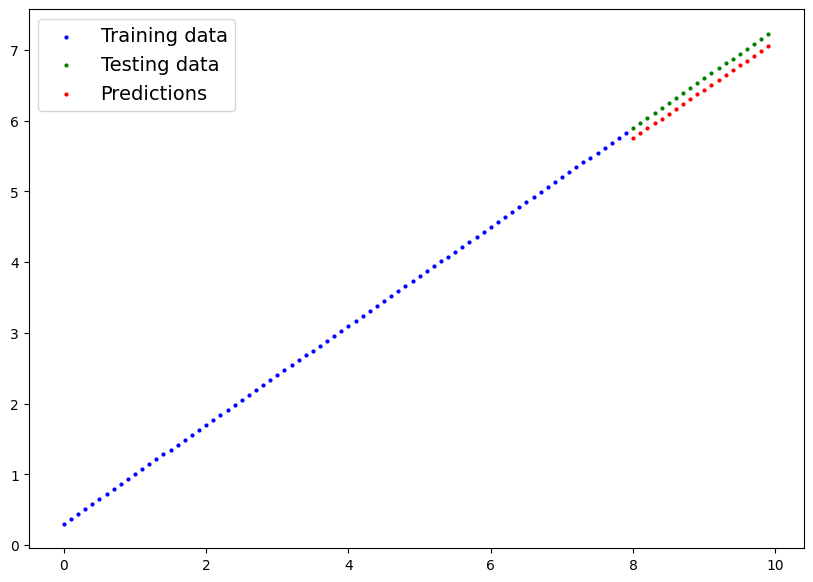

In [116]:
model_2.eval()
with torch.inference_mode():
    y_reg_pred = model_2(X_regression_test)
    
plot_predictions(train_data=X_regression_train, train_labels=y_regression_train, test_data=X_regression_test, test_labels=y_regression_test, predictions=y_reg_pred)

## 6. The missing piece: non-linearity

"What pattern could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear funcitons?

### 6.1 Recreating non-linear data (red and blue circles)

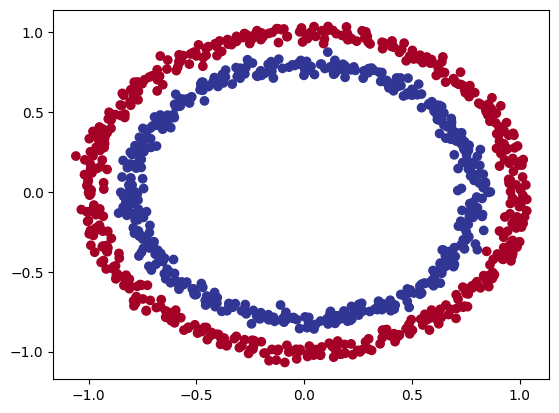

In [162]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X1, y1 = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X1[:, 0], X1[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [163]:
# convert data to tensor sand then to train and test splits
import torch 
from sklearn.model_selection import train_test_split

#Turn data into tensors
X1 = torch.from_numpy(X1).type(torch.float)
y1 = torch.from_numpy(y1).type(torch.float)

# split into train
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, 
                                                    y1, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )

X1_train[:5], y1_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Buliding a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural network are a large combination of linear (straight) and non-straight (non-linear) functions which are potenstially able to find patterns in data

In [165]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self) :
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=32) 
        self.layer_2 = nn.Linear(in_features=32, out_features=32)
        self.layer_3 = nn.Linear(in_features=32, out_features=1)
        self.relu = nn.ReLU() # relu is a non-linear activation function
        
    def forward(self, X):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))
    
model_3 = CircleModelV2().to(device=device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [166]:
# setup loss and optimizer
loss_fn_3 = nn.BCEWithLogitsLoss()
optimizer3 = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [167]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put all data on target device
X1_train, y1_train = X1_train.to(device=device), y1_train.to(device=device)
X1_test, y1_test = X1_test.to(device=device), y1_test.to(device=device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### training
    model_3.train()
    
    # forward pass
    y1_logits = model_3.forward(X1_train).squeeze()
    y1_pred = torch.round(torch.sigmoid(y1_logits))
    
    # calculate the loss/acc
    loss = loss_fn_3(y1_logits, y1_train)
    acc1 = accuracy_fn(y_true=y1_train, y_pred=y1_pred)
    
    # optimizer zero grad
    optimizer3.zero_grad()
    
    # loss backwards (backpropagation)
    loss.backward()
    
    # optimizer step (gradient descent)
    optimizer3.step()
    
    
    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # forward pass
        test1_logit = model_3.forward(X1_test).squeeze()
        test1_pred = torch.round(torch.sigmoid(test1_logit))
        
        # calculate the loss
        test1_loss = loss_fn_3(test1_logit, y1_test)
        test1_acc = accuracy_fn(y_true=y1_test, y_pred=test1_pred)
        
    # print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_1:.5f}, Acc: {acc1:.2f}% | Test loss: {test_loss_1:.5f}, Test acc: {test1_acc:.2f}%")
        
        

Epoch: 0 | Loss: 0.69369, Acc: 50.00% | Test loss: 0.69269, Test acc: 50.00%
Epoch: 10 | Loss: 0.69369, Acc: 50.62% | Test loss: 0.69269, Test acc: 47.00%
Epoch: 20 | Loss: 0.69369, Acc: 51.62% | Test loss: 0.69269, Test acc: 51.00%
Epoch: 30 | Loss: 0.69369, Acc: 51.25% | Test loss: 0.69269, Test acc: 51.00%
Epoch: 40 | Loss: 0.69369, Acc: 50.50% | Test loss: 0.69269, Test acc: 49.00%
Epoch: 50 | Loss: 0.69369, Acc: 50.12% | Test loss: 0.69269, Test acc: 47.50%
Epoch: 60 | Loss: 0.69369, Acc: 53.75% | Test loss: 0.69269, Test acc: 50.00%
Epoch: 70 | Loss: 0.69369, Acc: 56.00% | Test loss: 0.69269, Test acc: 49.50%
Epoch: 80 | Loss: 0.69369, Acc: 61.38% | Test loss: 0.69269, Test acc: 54.00%
Epoch: 90 | Loss: 0.69369, Acc: 63.25% | Test loss: 0.69269, Test acc: 60.00%
Epoch: 100 | Loss: 0.69369, Acc: 63.62% | Test loss: 0.69269, Test acc: 57.00%
Epoch: 110 | Loss: 0.69369, Acc: 61.25% | Test loss: 0.69269, Test acc: 56.50%
Epoch: 120 | Loss: 0.69369, Acc: 58.88% | Test loss: 0.69269, T

### 6.4 Evaluating a model trained with non-linear activation functions

In [168]:
# make predictions
model_3.eval()
with torch.inference_mode():
    y1_preds = torch.round(torch.sigmoid(model_3(X1_test))).squeeze()
    
y1_preds[:10], y1_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

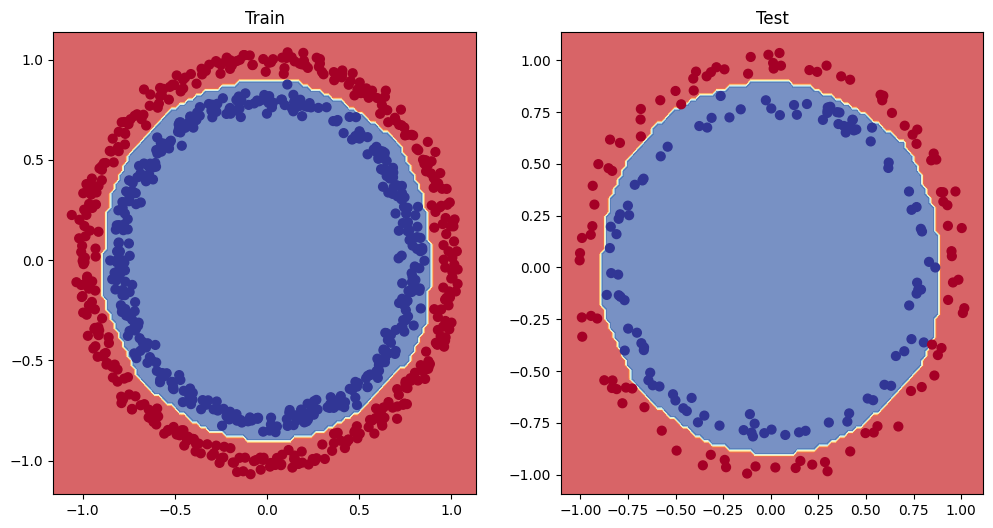

In [169]:
#plot desicion boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X1_train, y1_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X1_test, y1_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than telling the model what to learn, we give it the tools to discover patterns in data and it tries to figuure ou the best patterns on it own

And these tools are linear & non-linear functions

In [170]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

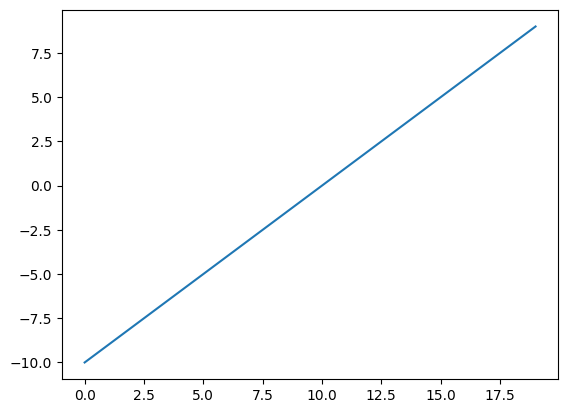

In [171]:
# Visualise
plt.plot(A)

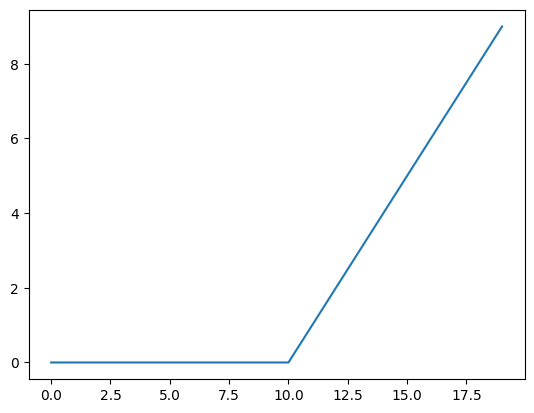

In [172]:
plt.plot(torch.relu(A))

In [173]:
def relu(x:torch.Tensor)-> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # input must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

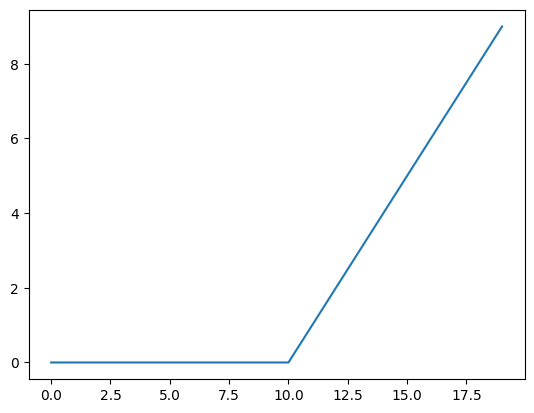

In [174]:
# plot ReLy activation function
plt.plot(relu(A))

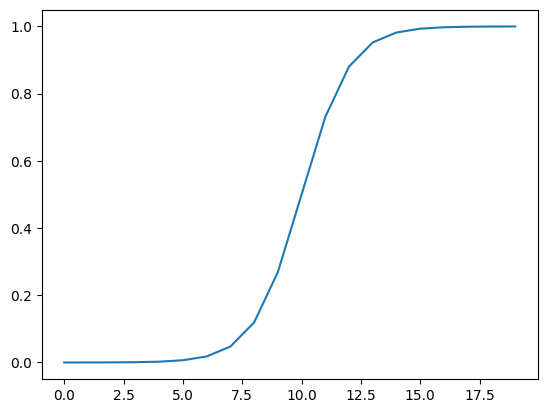

In [175]:
# do same for sigmoid
def sigmod(x):
    return 1 / (1 + torch.exp(-x))

plt.plot(torch.sigmoid(A))

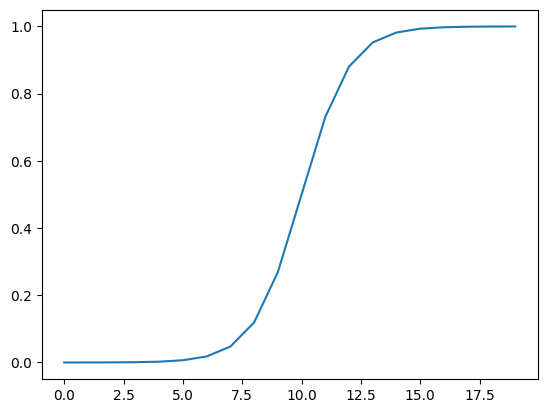

In [176]:
plt.plot(sigmod(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification  = one thing or anthter (cat vs dog, spam vs not spam, fraud or not fraud)
* Mult-class classification = more that one thing or another (cat vs dog vs chicken)